In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.pex.config

import lsst.afw.table
import lsst.meas.algorithms
import lsst.pex.exceptions
import lsst.meas.extensions.gaap

In [2]:
from astropy.io import fits
from astropy.table import Table, hstack
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

get existing patches

In [3]:
import os
old_patches = [name for name in os.listdir(
    "/projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/")]
new_patches = [int(name[0]) + int(name[2]) * 9 for name in old_patches]
merian_patches = [int(name) for name in os.listdir(
    "/projects/MERIAN/repo/DECam/runs/merian/dr1_wide/20220921T193246Z/deepCoadd_forced_src/9813")]
common_patches = np.intersect1d(new_patches, merian_patches)

rsync -azv --progress jiaxuanl@tiger.princeton.edu://projects/MERIAN/repo/S20A/gaapTable/9813/6,2/gaapTable_I_9813_6,2.fits ./

In [4]:
common_patches[20:23]

array([23, 24, 25])

In [48]:
from hsc_gaap.gaap import GaapTask
gaap = GaapTask(9813, 23, 'i', 
                hsc_type='S20A',
                repo='/projects/MERIAN/repo/', 
                collections='S20A/deepCoadd_calexp')
gaap._checkHSCfile()
gaap.load_merian_reference(band='N708', 
                           repo='/projects/MERIAN/repo/', 
                           collections='DECam/runs/merian/dr1_wide',
                           range=(0, 15000)
                          )
# gaap.refCat = gaap.refCat[:15000] # [4692:27041:(27040-4692)]
# gaap.refCatInBand = gaap.refCatInBand[:15000] # [4692:27041:(27040-4692)]
gaap.setDefaultMeasureConfig()
gaap.run()

Loaded HSC S20A deepCoadd_calexp image
Loaded Merian reference catalog and image
# Starting the GAaP measureTask at  Fri Nov 11 18:24:54 2022


Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_4 because could not find ext_gaap_GaapFlux_1_15x_0_4_instFlux or ext_gaap_GaapFlux_1_15x_0_4_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_5 because could not find ext_gaap_GaapFlux_1_15x_0_5_instFlux or ext_gaap_GaapFlux_1_15x_0_5_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_6 because could not find ext_gaap_GaapFlux_1_15x_0_6_instFlux or ext_gaap_GaapFlux_1_15x_0_6_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_7 because could not find ext_gaap_GaapFlux_1_15x_0_7_instFlux or ext_gaap_GaapFlux_1_15x_0_7_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_1_0 because could not find ext_gaap_GaapFlux_1_15x_1_0_instFlux or ext_gaap_GaapFlux_1_15x_1_0_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_1_5 because could not find ext_gaap_GaapFlux_1_15x_1_5_instFlux or ext_gaap_GaapFlux_1_15x_1_5_instFluxErr in ap

# Finished the GAaP measureTask in 797.74 seconds.


In [61]:
def writeObjectTable(measCat, band='i', save=True):
    import astropy.units as u
    from astropy.table import QTable
    
    outCat = measCat.copy(deep=True).asAstropy()
    outCat['coord_ra'] = outCat['coord_ra'].to(u.deg)
    outCat['coord_dec'] = outCat['coord_dec'].to(u.deg)

    old_gaap_cols = [
        item for item in measCat.schema.getNames() if ('gaap' in item and 'apCorr' not in item) | ('base_PsfFlux_instFlux' in item) | ('base_CircularApertureFlux' in item)]
    outCat = outCat[['id', 'coord_ra', 'coord_dec'] + old_gaap_cols]
    
    # PhotCalib
    for col in old_gaap_cols:
        if 'instFlux' in col:
            outCat[col] = outCat[col].value * \
                gaap.exposure.getPhotoCalib().instFluxToNanojansky(1) * u.nanomaggy

    new_gaap_cols = []
    for col in old_gaap_cols:
        name = col.replace('ext_gaap_GaapFlux', f'{band}_gaap')
        name = name.replace('_instFlux', 'Flux').replace('PsfFlux', 'Psf')
        if 'Flux' in name:
            aper = name.split(
                "x_")[-1].replace('FluxErr', '').replace('Flux', '')
            name = name.replace('_1_15x', '')
            name = name.replace('_' + aper, aper.replace('_', 'p'))

        if 'flag' in name:
            aper = name.split(
                "x_")[-1].replace('_flag_bigPsf', '').replace('_flag', '')
            name = name.replace('_1_15x', '')
            if not 'gauss' in name:
                name = name.replace(
                    '_' + aper, aper.replace('_', 'p') + 'Flux')
        new_gaap_cols.append(name)
    
    outCat.rename_columns(old_gaap_cols, new_gaap_cols)
    outCat = QTable(outCat)
    return outCat

In [62]:
cat2 = writeObjectTable(gaap.measCat, band='i')

In [72]:
from hsc_gaap.gaap import joinMerianCatPatches
cat2 = writeObjectTable(gaap.measCat, band='i')
cat2.remove_columns(['id', 'coord_ra', 'coord_dec'])
cat_ref = joinMerianCatPatches([23])

In [73]:
cat = hstack([cat_ref, cat2])
cat.write('/projects/MERIAN/repo/S20A/gaapTable/9813/gaap_9813_23_Merian_S20A_i_more.fits', overwrite=True)

In [73]:
# gaap.run()

In [17]:
outcat = gaap.writeObjectTable(save=False)

In [19]:
good_objects = ~(outcat["i_gaap_flag"] | outcat['i_gaapOptimalFlux_flag_bigPsf'])
np.sum(good_objects), len(good_objects)

(6643, 15000)

Text(0.5, 0, 'Sigmas')

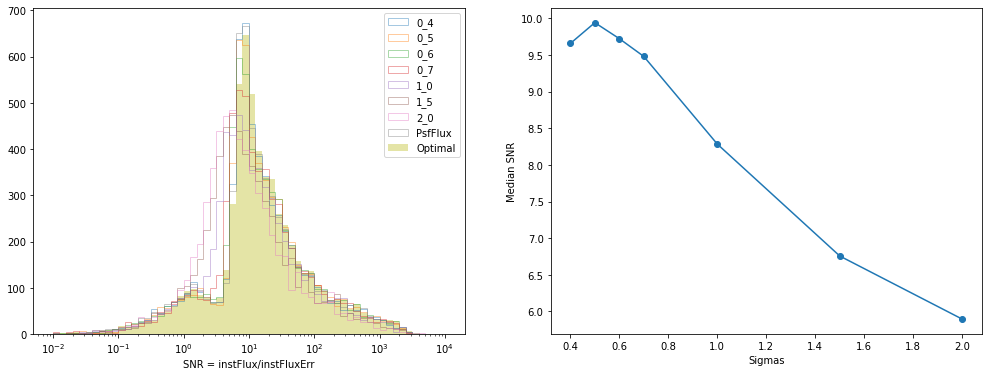

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(17,6))
bins = np.logspace(-2, 4, 61)

baseNames = list(gaap.measureConfig.measurement.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"))
statistic_list = []
statistic_upper_list, statistic_lower_list = [], []

for baseName in gaap.measureConfig.measurement.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"):
    label = baseName.split("x_")[-1]
    #if label[-1]=='5': continue
#     if "PsfFlux" in label: continue
    histtype='stepfilled' if "Optimal" in baseName else 'step'
    snr = gaap.measCat[baseName+"_instFlux"][good_objects] / gaap.measCat[baseName+"_instFluxErr"][good_objects]
    ax[0].hist(snr, bins=bins, histtype=histtype,label=label, alpha=0.4)
    statistic = np.nanpercentile(snr, 50)
    # statistic = np.nanmean(snr)
    if "Optimal" in label:
        optStatistic = np.nanpercentile(snr, 50)
    if not ("PsfFlux" in label or "Optimal" in label):
        statistic_list.append(statistic)
        statistic_upper_list.append(np.percentile(snr, 84))
        statistic_lower_list.append(np.percentile(snr, 16))

ax[0].set_xscale('log')
ax[0].set_xlabel("SNR = instFlux/instFluxErr")
#ax[0].set_yscale('log')
ax[0].legend(loc='best')

sigmas = gaap.measureConfig.measurement.plugins["ext_gaap_GaapFlux"].sigmas.list()
ax[1].plot(sigmas, statistic_list, 'o-')
#ax[1].fill_between(sigmas, statistic_upper_list, statistic_lower_list, alpha=0.4)
# ax[1].plot(3.6, optStatistic, "*", markersize=12)
ax[1].set_ylabel("Median SNR")
ax[1].set_xlabel("Sigmas")
# ax[1].axvline(3.5, color='k', ls='-.')

In [7]:
measureConfig = gaap.measureConfig.measurement

In [8]:
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom

In [10]:
recordId = 4692
shape = gaap.refCat[0].getShape()
shape

Quadrupole(ixx=34.45119236706474, iyy=41.52509442420149, ixy=7.882154670230213)

In [11]:
afwDisplay.setDefaultBackend('matplotlib')
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")
display.setMaskTransparency(80)
obj = gaap.refCatInBand[recordId]
footprint = obj.getFootprint()
bbox = footprint.getBBox()
cutout = gaap.exposure[bbox]
display.mtv(cutout)
display.dot(shape, *obj.getCentroid()) #*bbox.getCenter())
# ax[1].set_title(f"recordId = {recordId}")

RuntimeError: Unable to set backend to matplotlib: "module 'matplotlib' has no attribute 'DisplayImpl'"

In [241]:
np.where(gaap.refCat['id'] == 3495906016606815036)

(array([], dtype=int64),)

In [184]:
gaap.refCat[recordId]['coord_ra'], gaap.refCatInBand[recordId]['coord_ra']

(Angle(150.13787587649813, degrees), Angle(150.13787587649813, degrees))

In [185]:
gaap.refCat[recordId]['coord_dec'], gaap.refCatInBand[recordId]['coord_dec']

(Angle(1.9039421833395893, degrees), Angle(1.9039421833395893, degrees))

In [155]:
f = gaap.refCatInBand[recordId].getFootprint()

In [156]:
f.getRegion()

Box2I(corner=Point2I(0, 0), dimensions=Extent2I(0, 0))

In [279]:
gaap.refCat[recordId].getFootprint(), gaap.refCatInBand[recordId].getFootprint()

(1 peaks, area=197, centroid=(26260, 9329),
 1 peaks, area=1433, centroid=(25757.5, 8038.73))

In [280]:
gaap.refCat[recordId].getCentroid(), gaap.refCatInBand[recordId].getCentroid()

(Point2D(25755.02371535539, 8036.9627385319982),
 Point2D(25755.02371535539, 8036.9627385319982))

In [281]:
gaap.refCat[recordId]['coord_ra'], gaap.refCat[recordId]['coord_dec']

(Angle(149.88583075202334, degrees), Angle(1.7664848325281512, degrees))

In [282]:
gaap.refCatInBand[recordId]['coord_ra'], gaap.refCatInBand[recordId]['coord_dec']

(Angle(149.88583075202334, degrees), Angle(1.7664848325281512, degrees))

In [84]:
gaap.exposure.writeFits('//projects/MERIAN/repo/S20A//test.fits')

In [79]:
footprint

10 peaks, area=2524, centroid=(23070.4, 7936.81)

3.8075322042763746


Text(0.5, 1.0, 'recordId = 44')

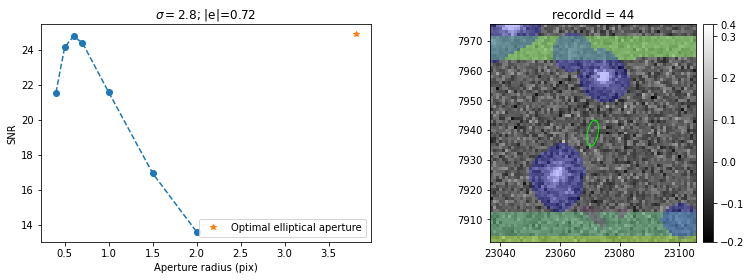

In [72]:
recordId = 44
scalingFactor = 1.15

def printShape(shape):
    ixx, iyy, ixy = shape.getParameterVector()
    det = shape.getDeterminantRadius()
    complex_ellip = ((ixx-iyy)+1j*2*ixy)/(ixx+iyy)
    ellip = np.hypot(complex_ellip.real, complex_ellip.imag)
#     return f"Quad(ixx={ixx:.2f}, iyy={iyy:.2f}, ixy={ixy:.2f}); det={det:.1f}; |e|={ellip:.2f}"
    return rf"$\sigma = ${det:.1f}; |e|={ellip:.2f}"

def getSnr(sigmas):
    for sigma in sigmas:
        baseName = measureConfig.plugins["ext_gaap_GaapFlux"]._getGaapResultName(scalingFactor, sigma, "ext_gaap_GaapFlux")
        snr = gaap.measCat[recordId][baseName+"_instFlux"]/gaap.measCat[recordId][baseName+"_instFluxErr"]
        yield snr
        
sigmas = np.array(measureConfig.plugins["ext_gaap_GaapFlux"].sigmas)
snrs = np.array(list(getSnr(sigmas)))

fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].plot(sigmas[snrs>0], snrs[snrs>0], 'o--')

shape = gaap.measCat[recordId].getShape()
optShape = afwGeom.Quadrupole(gaap.measCat[recordId]["ext_gaap_GaapFlux_OptimalShape_xx"],
                              gaap.measCat[recordId]["ext_gaap_GaapFlux_OptimalShape_yy"],
                              gaap.measCat[recordId]["ext_gaap_GaapFlux_OptimalShape_xy"],)
sigma = optShape.getDeterminantRadius()
print(sigma)
snr = list(getSnr(("Optimal",)))[0]
ax[0].plot(sigma, snr, '*', label='Optimal elliptical aperture')

ax[0].set_ylabel("SNR")
ax[0].set_xlabel("Aperture radius (pix)")
ax[0].set_title(printShape(shape))
#plt.yscale('log')
ax[0].legend(loc='best')


afwDisplay.setDefaultBackend('matplotlib')
plt.sca(ax[1])
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")
# display.setMaskTransparency(100)
footprint = gaap.refCat[recordId].getFootprint()
bbox = footprint.getBBox()
cutout = gaap.exposure[bbox]
display.mtv(cutout)
display.dot(shape, *bbox.getCenter())
ax[1].set_title(f"recordId = {recordId}")

In [64]:
shape

Quadrupole(ixx=3.7529623506152876, iyy=19.116250473270973, ixy=3.007067162054985)